# Data Collection

In [ ]:
import serial
import numpy as np
import os
import time
import csv

# Configuration des paramètres
SERIAL_PORT = "/dev/ttyACM0"
BAUD_RATE = 115200
NUM_SAMPLES = 1024
SAMPLE_RATE = 88200
MAX_DISPLAY_FREQ = 22000
DURATION = 20  # Durée d'enregistrement
SAVE_DIR = "collected_data"
FILENAME = "spectrogram_data_no_leak.csv"

os.makedirs(SAVE_DIR, exist_ok=True)
filepath = os.path.join(SAVE_DIR, FILENAME)

ser = serial.Serial(SERIAL_PORT, BAUD_RATE)
print(f"Collecting data for {DURATION} seconds...")

start_time = time.time()
with open(filepath, mode="w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["fft_value_" + str(i) for i in range(NUM_SAMPLES // 2)])

    try:
        while time.time() - start_time < DURATION:
            if ser.in_waiting:
                try:
                    data = ser.readline().decode().strip()
                    fft_data = [float(x) for x in data.split(",") if x]
                    if len(fft_data) == NUM_SAMPLES // 2:
                        writer.writerow(fft_data)
                    else:
                        print(f"Unexpected FFT data length: {len(fft_data)}")
                except Exception as e:
                    print(f"Error reading data: {e}")
    finally:
        ser.close()
        print(f"Data saved to {filepath}")


Error reading data: could not convert string to float: '23.20.88'
Data saved to collected_data/spectrogram_data.csv


In [ ]:
import serial
import numpy as np
import os
import time
import csv

# Configuration des paramètres
SERIAL_PORT = "/dev/ttyACM0"
BAUD_RATE = 115200
NUM_SAMPLES = 1024
SAMPLE_RATE = 88200
MAX_DISPLAY_FREQ = 22000
DURATION = 20  # Durée d'enregistrement
SAVE_DIR = "collected_data"
FILENAME = "spectrogram_data_leak.csv"

os.makedirs(SAVE_DIR, exist_ok=True)
filepath = os.path.join(SAVE_DIR, FILENAME)

ser = serial.Serial(SERIAL_PORT, BAUD_RATE)
print(f"Collecting data for {DURATION} seconds...")

start_time = time.time()
with open(filepath, mode="w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["fft_value_" + str(i) for i in range(NUM_SAMPLES // 2)])

    try:
        while time.time() - start_time < DURATION:
            if ser.in_waiting:
                try:
                    data = ser.readline().decode().strip()
                    fft_data = [float(x) for x in data.split(",") if x]
                    if len(fft_data) == NUM_SAMPLES // 2:
                        writer.writerow(fft_data)
                    else:
                        print(f"Unexpected FFT data length: {len(fft_data)}")
                except Exception as e:
                    print(f"Error reading data: {e}")
    finally:
        ser.close()
        print(f"Data saved to {filepath}")


# Visualisation

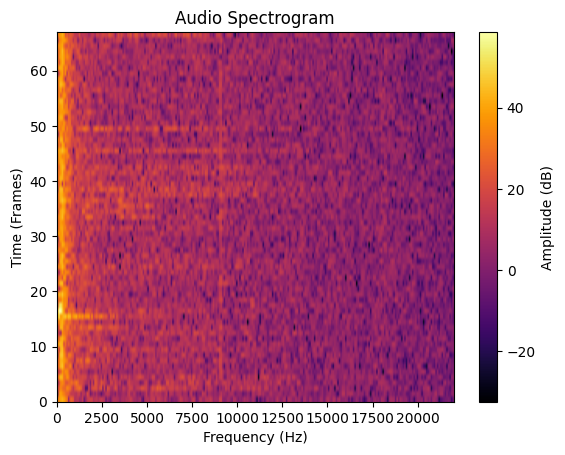

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

SAVE_DIR = "collected_data"
FILENAME_LEAK = "spectrogram_data_leak.csv"
FILENAME_NO_LEAK = "spectrogram_data_no_leak.csv"
NUM_SAMPLES = 1024
SAMPLE_RATE = 88200
MAX_DISPLAY_FREQ = 22000

def load_and_plot_spectrogram(filename, title):
    filepath = os.path.join(SAVE_DIR, filename)
    if not os.path.exists(filepath):
        print(f"Fichier {filepath} introuvable. Assurez-vous d'avoir collecté les données.")
        return

    data = pd.read_csv(filepath).to_numpy()
    time_steps, freq_bins = data.shape
    frequencies = np.linspace(0, SAMPLE_RATE / 2, freq_bins)
    freq_limit_idx = int((MAX_DISPLAY_FREQ / (SAMPLE_RATE / 2)) * freq_bins)
    frequencies = frequencies[:freq_limit_idx]

    spectrogram_data = data[:, :freq_limit_idx]

    fig, ax = plt.subplots()
    cax = ax.imshow(
        spectrogram_data,
        extent=[0, MAX_DISPLAY_FREQ, 0, time_steps],
        aspect="auto",
        cmap="inferno",
        origin="lower",
    )
    fig.colorbar(cax, ax=ax, label="Amplitude (dB)")
    ax.set_xlabel("Frequency (Hz)")
    ax.set_ylabel("Time (Frames)")
    ax.set_title(title)

    plt.show()

# Plot spectrogram for leak data
load_and_plot_spectrogram(FILENAME_LEAK, "Audio Spectrogram with Leak")

# Plot spectrogram for no leak data
load_and_plot_spectrogram(FILENAME_NO_LEAK, "Audio Spectrogram without Leak")
